In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [2]:
PATH = '/Users/francis/Desktop/wines_properties.csv'
df = pd.read_csv(PATH)

In [3]:
df.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Customer_Segment
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


### Linear regression

In [4]:
# formula
formula = '''
Alcohol ~ Malic_Acid + Ash + Ash_Alcanity + Magnesium + Total_Phenols + Flavanoids 
+ Nonflavanoid_Phenols + Proanthocyanins + Color_Intensity + Hue + OD280 + Proline
'''
# fit the model
results = smf.ols(formula, data=df).fit()

In [5]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                Alcohol   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     20.08
Date:                Sun, 09 Dec 2018   Prob (F-statistic):           1.61e-26
Time:                        16:45:37   Log-Likelihood:                -134.83
No. Observations:                 178   AIC:                             295.7
Df Residuals:                     165   BIC:                             337.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               11.0718 

### Logistic regression

In [6]:
# create label
df['alcohol_type'] = (df['Alcohol'] > np.percentile(df['Alcohol'], 75)).map(int)
# formula
formula_logit = '''
alcohol_type ~ Malic_Acid + Ash + Ash_Alcanity + Magnesium + Total_Phenols + Flavanoids 
+ Nonflavanoid_Phenols + Proanthocyanins + Color_Intensity + Hue + OD280 + Proline
'''
# fit the logistic regression model
results_logit = sm.Logit.from_formula(formula_logit, data=df).fit()

Optimization terminated successfully.
         Current function value: 0.333006
         Iterations 8


In [7]:
print(results_logit.summary())

                           Logit Regression Results                           
Dep. Variable:           alcohol_type   No. Observations:                  178
Model:                          Logit   Df Residuals:                      165
Method:                           MLE   Df Model:                           12
Date:                Sun, 09 Dec 2018   Pseudo R-squ.:                  0.4110
Time:                        16:45:37   Log-Likelihood:                -59.275
converged:                       True   LL-Null:                       -100.64
                                        LLR p-value:                 1.240e-12
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              -15.7261      4.579     -3.435      0.001     -24.700      -6.752
Malic_Acid               0.6820      0.302      2.259      0.024       0.090       1.274
Ash         

### Logistic regression with PCA:

In [8]:
# select every column except 'Alcohol', 'alcohol_type', and 'Customer_Segment':
regressors = df.drop(['Alcohol', 'alcohol_type', 'Customer_Segment'], axis=1)
# PCA transformation on the data
pca = sm.PCA(data=regressors)

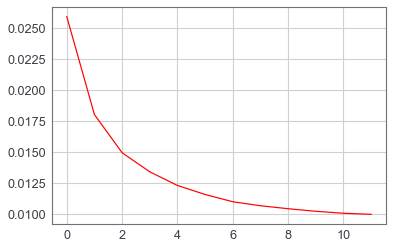

In [9]:
# plot the variance explained
eigenvalue_sum = np.sum(pca.eigenvals)
sorted_eigenvalues = sorted(pca.eigenvals, reverse=True)
variance_explained = [(i / eigenvalue_sum)*100 for i in sorted_eigenvalues]
plt.plot(1 / np.cumsum(variance_explained), color='red')
plt.show()

In [10]:
sm.PCA?

From the above plot, we decide to select the first 4 principal components as regressors.

In [11]:
# Logistic regression with principal components:

# prepare the data table
pca_regression_table  = pca.factors.loc[:, ('comp_00', 'comp_01', 'comp_02', 'comp_03')]
pca_regression_table['alcohol_type'] = df['alcohol_type']
# write the formula
formula_pca = 'alcohol_type ~ comp_00 + comp_01 + comp_02 + comp_03'
# fit the logistic regression model
results_pca = sm.Logit.from_formula(formula_pca, data=pca_regression_table).fit()

Optimization terminated successfully.
         Current function value: 0.395535
         Iterations 7


In [12]:
print(results_pca.summary())

                           Logit Regression Results                           
Dep. Variable:           alcohol_type   No. Observations:                  178
Model:                          Logit   Df Residuals:                      173
Method:                           MLE   Df Model:                            4
Date:                Sun, 09 Dec 2018   Pseudo R-squ.:                  0.3004
Time:                        16:45:38   Log-Likelihood:                -70.405
converged:                       True   LL-Null:                       -100.64
                                        LLR p-value:                 2.308e-12
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.6548      0.268     -6.175      0.000      -2.180      -1.130
comp_00      -12.4494      2.852     -4.366      0.000     -18.038      -6.860
comp_01       17.3972      3.665      4.747      0.0

----
### Model Performance
As we can see from the summary table of the OLS regression, the $R^2$ is $0.594$.

For comparing the accuracy of prediction for the two approaches (no PCA vs. PCA) of logistic regression, we do two things:

* Draw ROC curves of the two models and compare the area under the ROC curves (AUC).
* Calculate accuracy of the two models using optimal thresholds


In [13]:
from sklearn.metrics import roc_curve, auc, accuracy_score

In [14]:
# ROC curve and AUC score without PCA
fpr, tpr, thresholds = roc_curve(df.alcohol_type, results_logit.predict())
roc_auc = auc(fpr,tpr)

# ROC curve and AUC score with PCA
fpr_pca, tpr_pca, thresholds_pca = roc_curve(df.alcohol_type, results_pca.predict())
roc_auc_pca = auc(fpr_pca,tpr_pca)

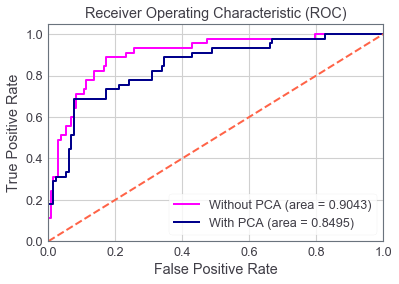

In [15]:
# Plot the two ROC curves
plt.plot(fpr, tpr, color='magenta',
         lw=2, label='Without PCA (area = %0.4f)' % roc_auc)

plt.plot(fpr_pca, tpr_pca, color='darkblue',
         lw=2, label='With PCA (area = %0.4f)' % roc_auc_pca)

plt.plot([0, 1], [0, 1], color='tomato', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Receiver Operating Characteristic (ROC)')
plt.show()

With PCA, the model performs even worse.....